In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

N_EPOCHES = 50
BATCH_SIZE = 64
PATCH_DIMENSIONS = (128, 128)
DATA_LOCATION = r"D:\data\malaria_dataset"

# Transfer learning 101

In this notebook we will be using the maleria dataset: https://lhncbc.nlm.nih.gov/publication/pub9932
We will just load the data in and resize it to 128x128 without looking to much into pre-processing or hyper parameter tuning given it is outside the scope of this session.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(validation_split=0.3, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, rotation_range=15, zoom_range=0.5)
train_generator = data_generator.flow_from_directory(DATA_LOCATION, target_size=PATCH_DIMENSIONS, batch_size=BATCH_SIZE, subset="training")
validation_generator = data_generator.flow_from_directory(DATA_LOCATION, target_size=PATCH_DIMENSIONS, batch_size=BATCH_SIZE, subset="validation")

Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


## Let's have a look at the data we are dealing with

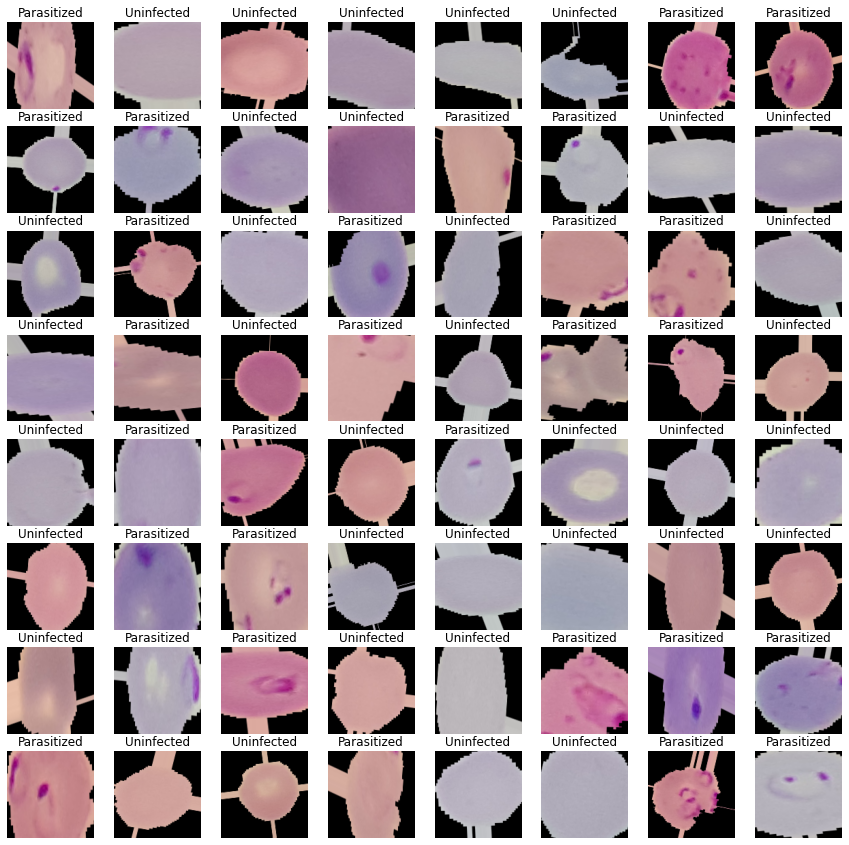

In [3]:
import matplotlib.pyplot as plt
import numpy as np
X, Y = train_generator.__getitem__(0)

classes = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(8, 8,figsize=(15,15))
for x in range(8):
    for y in range(8):
        axes[x][y].imshow((X[x*8 + y]).astype("uint8"))
        class_num = int(np.argmax(Y[x*8 + y]))
        class_name = classes[class_num]
        axes[x][y].title.set_text(class_name)
        axes[x][y].axis('off')

plt.show()

## Getting the model
We will download the [EfficientNet B0](https://arxiv.org/abs/1905.11946). This is a network optimized to have as little FLOPS for the maximum accuracy. The network can be downloaded with and without pre-trained weights. The pre-trained weights are trained on the [imageNet Challange](http://image-net.org/). These are nature image made with normale camera's of everyday objects.

In this notebook we are gone to see what a difference it makes to have 

In [4]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model

def create_model(weights="imagenet"):
    n_classes = len(classes)
    pre_trained_model = EfficientNetB0(include_top=False, weights=weights)

    input_layer = pre_trained_model.input
    max_pool = MaxPooling2D((4, 4))(pre_trained_model.output)

    dense1 = Dense(n_classes, activation="softmax")(max_pool)
    flat = Flatten()(dense1)

    model = Model(input_layer, flat)

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']
    )
    return model

In [5]:
model_no_pretrain = create_model(None)
history = model_no_pretrain.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/50
302/302 [==============================] - 352s 1s/step - loss: 0.8860 - accuracy: 0.5360 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/50
302/302 [==============================] - 112s 372ms/step - loss: 0.6416 - accuracy: 0.6789 - val_loss: 0.4771 - val_accuracy: 0.7753
Epoch 3/50
302/302 [==============================] - 119s 394ms/step - loss: 0.3157 - accuracy: 0.8812 - val_loss: 0.3407 - val_accuracy: 0.8686
Epoch 4/50
302/302 [==============================] - 115s 380ms/step - loss: 0.2665 - accuracy: 0.9073 - val_loss: 0.2449 - val_accuracy: 0.9101
Epoch 5/50
302/302 [==============================] - 115s 381ms/step - loss: 0.2510 - accuracy: 0.9111 - val_loss: 0.2301 - val_accuracy: 0.9136
Epoch 6/50
302/302 [==============================] - 115s 382ms/step - loss: 0.2362 - accuracy: 0.9162 - val_loss: 0.2578 - val_accuracy: 0.9019
Epoch 7/50
302/302 [==============================] - 116s 385ms/step - loss: 0.2200 - accuracy: 0.9221 - val_loss: 0.2139 - va

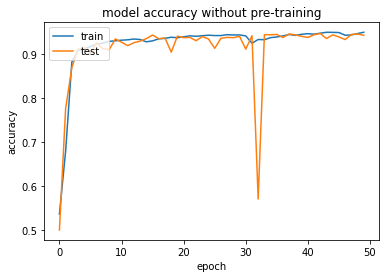

In [6]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy without pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

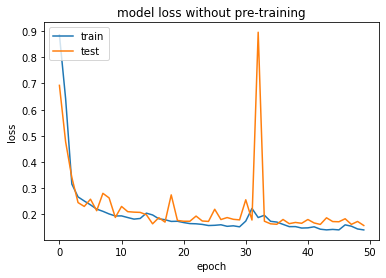

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss without pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
model_with_pretrain = create_model("imagenet")
history = model_with_pretrain.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/50
302/302 [==============================] - 114s 379ms/step - loss: 0.3071 - accuracy: 0.9125 - val_loss: 0.1851 - val_accuracy: 0.9375
Epoch 2/50
302/302 [==============================] - 114s 378ms/step - loss: 0.1726 - accuracy: 0.9357 - val_loss: 0.1688 - val_accuracy: 0.9399
Epoch 3/50
302/302 [==============================] - 113s 375ms/step - loss: 0.1628 - accuracy: 0.9412 - val_loss: 0.1436 - val_accuracy: 0.9491
Epoch 4/50
302/302 [==============================] - 113s 375ms/step - loss: 0.1462 - accuracy: 0.9465 - val_loss: 0.1444 - val_accuracy: 0.9477
Epoch 5/50
302/302 [==============================] - 113s 375ms/step - loss: 0.1362 - accuracy: 0.9509 - val_loss: 0.1549 - val_accuracy: 0.9447
Epoch 6/50
302/302 [==============================] - 114s 377ms/step - loss: 0.1597 - accuracy: 0.9433 - val_loss: 0.1660 - val_accuracy: 0.9466
Epoch 7/50
302/302 [==============================] - 114s 376ms/step - loss: 0.1688 - accuracy: 0.9411 - val_loss: 0.1840 -

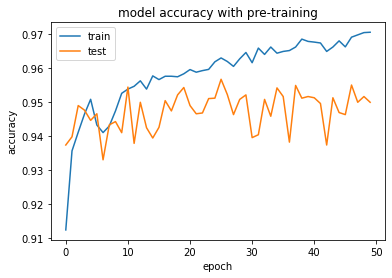

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

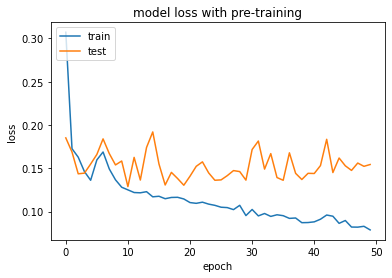

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()